### TODO
- passing in callbacks

In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [3]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### load dataset

In [4]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

### modules

In [5]:
import numpy as np
import tensorflow as tf
from umap import UMAP
from warnings import warn, catch_warnings, filterwarnings
from umap.umap_ import make_epochs_per_sample
from numba import TypingError
import os

In [6]:
def get_graph_elements(graph_, n_epochs):
    """
    gets elements of graphs, weights, and number of epochs per edge

    Parameters
    ----------
    graph_ : [type]
        umap graph of probabilities
    n_epochs : int
        maximum number of epochs per edge

    Returns
    -------
    graph [type]
        umap graph
    epochs_per_sample np.array
        number of epochs to train each sample for
    head np.array
        edge head
    tail np.array
        edge tail
    weight np.array
        edge weight
    n_vertices int
        number of verticies in graph
    """
    ### should we remove redundancies () here??
    # graph_ = remove_redundant_edges(graph_)

    graph = graph_.tocoo()
    # eliminate duplicate entries by summing them together
    graph.sum_duplicates()
    # number of vertices in dataset
    n_vertices = graph.shape[1]
    # get the number of epochs based on the size of the dataset
    if n_epochs is None:
        # For smaller datasets we can use more epochs
        if graph.shape[0] <= 10000:
            n_epochs = 500
        else:
            n_epochs = 200
    # remove elements with very low probability
    graph.data[graph.data < (graph.data.max() / float(n_epochs))] = 0.0
    graph.eliminate_zeros()
    # get epochs per sample based upon edge probability
    epochs_per_sample = make_epochs_per_sample(graph.data, n_epochs)

    head = graph.row
    tail = graph.col
    weight = graph.data

    return graph, epochs_per_sample, head, tail, weight, n_vertices

In [7]:
from umap.spectral import spectral_layout
from sklearn.utils import check_random_state


def init_embedding_from_graph(
    _raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"
):
    """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
    if random_state is None:
        random_state = check_random_state(None)
    
    if isinstance(init, str) and init == "random":
        embedding = random_state.uniform(
            low=-10.0, high=10.0, size=(graph.shape[0], n_components)
        ).astype(np.float32)
    elif isinstance(init, str) and init == "spectral":
        # We add a little noise to avoid local minima for optimization to come

        initialisation = spectral_layout(
            _raw_data,
            graph,
            n_components,
            random_state,
            metric=metric,
            metric_kwds=_metric_kwds,
        )
        expansion = 10.0 / np.abs(initialisation).max()
        embedding = (initialisation * expansion).astype(
            np.float32
        ) + random_state.normal(
            scale=0.0001, size=[graph.shape[0], n_components]
        ).astype(
            np.float32
        )

    else:
        init_data = np.array(init)
        if len(init_data.shape) == 2:
            if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                tree = KDTree(init_data)
                dist, ind = tree.query(init_data, k=2)
                nndist = np.mean(dist[:, 1])
                embedding = init_data + random_state.normal(
                    scale=0.001 * nndist, size=init_data.shape
                ).astype(np.float32)
            else:
                embedding = init_data

    return embedding

In [8]:
def convert_distance_to_probability(distances, a, b):
    """ convert distance representation into probability, 
        as a function of a, b params
    """
    return 1.0 / (1.0 + a * distances ** (2 * b))

In [9]:
def compute_cross_entropy(
    probabilities_graph, probabilities_distance, EPS=1e-4, repulsion_strength=1.0
):
    """
    Compute cross entropy between low and high probability

    Parameters
    ----------
    probabilities_graph : [type]
        high dimensional probabilities
    probabilities_distance : [type]
        low dimensional probabilities
    EPS : [type], optional
        offset to to ensure log is taken of a positive number, by default 1e-4
    repulsion_strength : float, optional
        strength of repulsion between negative samples, by default 1.0

    Returns
    -------
    attraction_term: tf.float32
        attraction term for cross entropy loss
    repellant_term: tf.float32
        repellant term for cross entropy loss
    cross_entropy: tf.float32
        cross entropy umap loss
    
    """
    # cross entropy
    attraction_term = -probabilities_graph * tf.math.log(
        tf.clip_by_value(probabilities_distance, EPS, 1.0)
    )
    repellant_term = (
        -(1.0 - probabilities_graph)
        * tf.math.log(tf.clip_by_value(1.0 - probabilities_distance, EPS, 1.0))
        * repulsion_strength
    )

    # balance the expected losses between atrraction and repel
    CE = attraction_term + repellant_term
    return attraction_term, repellant_term, CE

In [10]:
def umap_loss(
    batch_size,
    negative_sample_rate,
    _a,
    _b,
    edge_weights,
    parametric_embedding,
    repulsion_strength=1.0,
):

    if not parametric_embedding:
        # multiply loss by weights for nonparametric
        weights_tiled = np.tile(edge_weights, negative_sample_rate + 1)

    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(
            embed_to_from, num_or_size_splits=2, axis=1
        )

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )

        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)], axis=0,
        )

        # compute cross entropy
        (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
            probabilities_graph,
            probabilities_distance,
            repulsion_strength=repulsion_strength,
        )

        if not parametric_embedding:
            ce_loss = ce_loss * weights_tiled

        return tf.reduce_mean(ce_loss)

    return loss

In [11]:
def prepare_networks(
    encoder,
    decoder,
    n_components,
    dims,
    n_data,
    parametric_embedding,
    parametric_reconstruction,
    init_embedding,
):

    if parametric_embedding:
        if encoder is None:
            encoder = tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=dims),
                    tf.keras.layers.Flatten(),
                    tf.keras.layers.Dense(units=100, activation="relu"),
                    tf.keras.layers.Dense(units=100, activation="relu"),
                    tf.keras.layers.Dense(units=100, activation="relu"),
                    tf.keras.layers.Dense(units=n_components, name="z"),
                ]
            )
    else:
        embedding_layer = tf.keras.layers.Embedding(
            n_data, n_components, input_length=1
        )
        embedding_layer.build(input_shape=(1,))
        embedding_layer.set_weights([init_embedding])
        encoder = tf.keras.Sequential([embedding_layer])

    if decoder is None:
        if parametric_reconstruction:
            decoder = tf.keras.Sequential(
                [
                    tf.keras.layers.InputLayer(input_shape=n_components),
                    tf.keras.layers.Dense(units=100, activation="relu"),
                    tf.keras.layers.Dense(units=100, activation="relu"),
                    tf.keras.layers.Dense(units=100, activation="relu"),
                    tf.keras.layers.Dense(
                        units=np.product(dims), name="recon", activation=None
                    ),
                    tf.keras.layers.Reshape(dims),
                ]
            )

    return encoder, decoder

In [12]:
def construct_edge_dataset(
    X,
    graph_,
    n_epochs,
    batch_size,
    max_sample_repeats_per_epoch,
    parametric_embedding,
    parametric_reconstruction,
):
    """ Construct a tf.data.Dataset of edges, sampled by edge weight.
    """

    def gather_X(edge_to, edge_from):
        edge_to_batch = tf.gather(X, edge_to)
        edge_from_batch = tf.gather(X, edge_from)
        outputs = {'umap': 0}
        if parametric_reconstruction:
            # add reconstruction to iterator output
            #edge_out = tf.concat([edge_to_batch, edge_from_batch], axis=0)
            outputs['reconstruction'] = edge_to_batch

        return (edge_to_batch, edge_from_batch), outputs

    def make_sham_generator():
        def sham_generator():
            while True:
                yield tf.zeros(1, dtype=tf.int32), tf.zeros(1, dtype=tf.int32)

        return sham_generator

    # get data from graph
    graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
        graph_, n_epochs
    )

    # number of elements per batch for embedding
    if batch_size is None:
        # batch size can be larger if its just over embeddings
        if parametric_embedding:
            batch_size = np.min([n_vertices, 60000])
        else:
            batch_size = len(head)

    edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
        np.repeat(tail, epochs_per_sample.astype("int")),
    )

    # shuffle edges
    shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
    edges_to_exp = edges_to_exp[shuffle_mask]
    edges_from_exp = edges_from_exp[shuffle_mask]

    # create edge iterator
    if parametric_embedding:
        edge_dataset = tf.data.Dataset.from_tensor_slices(
            (edges_to_exp, edges_from_exp)
        )
        edge_dataset = edge_dataset.repeat()
        edge_dataset = edge_dataset.shuffle(10000)
        edge_dataset = edge_dataset.map(
            gather_X, num_parallel_calls=tf.data.experimental.AUTOTUNE
        )
        edge_dataset = edge_dataset.batch(batch_size, drop_remainder=True)
        edge_dataset = edge_dataset.prefetch(10)
    else:
        # nonparametric embedding uses a sham dataset
        gen = make_sham_generator()
        edge_dataset = tf.data.Dataset.from_generator(gen, (tf.int32, tf.int32))
    return edge_dataset, batch_size, len(edges_to_exp), head, tail, weight

In [13]:
class ParametricUMAP(UMAP):
    def __init__(
        self,
        optimizer=None,
        batch_size=None,
        dims=None,
        encoder=None,
        decoder=None,
        parametric_embedding=True,
        parametric_reconstruction=False,
        autoencoder_loss=False,
        reconstruction_validation=None,
        max_sample_repeats_per_epoch=None,
        loss_report_frequency=1,
        n_training_epochs=1,
        keras_callbacks = [],
        **kwargs
    ):
        """ Parametric UMAP subclassing UMAP-learn, based on keras/tensorflow.
        There is also a non-parametric implementation contained within to compare 
        with the base non-parametric implementation.
        """
        super().__init__(**kwargs)

        # add to network
        self.dims = dims  # if this is an image, we should reshape for network
        self.encoder = encoder  # neural network used for embedding
        self.decoder = decoder  # neural network used for decoding
        self.parametric_embedding = (
            parametric_embedding  # nonparametric vs parametric embedding
        )
        self.parametric_reconstruction = parametric_reconstruction
        self.autoencoder_loss = autoencoder_loss
        self.max_sample_repeats_per_epoch = max_sample_repeats_per_epoch
        self.batch_size = batch_size
        self.loss_report_frequency = (
            loss_report_frequency  # how many times per epoch to report loss in keras
        )
        self.keras_callbacks = keras_callbacks # callbacks for training the network
        self.reconstruction_validation = (
            reconstruction_validation  # holdout data for reconstruction acc
        )
        
        self.parametric_model = None

        # how many epochs to train for (different than n_epochs which is specific to each sample)
        self.n_training_epochs = n_training_epochs
        # set optimizer
        if optimizer is None:
            if parametric_embedding:
                # Adam is better for parametric_embedding
                self.optimizer = tf.keras.optimizers.Adam(1e-3)
            else:
                # Larger learning rate can be used for embedding
                self.optimizer = tf.keras.optimizers.Adam(1e-1)
        else:
            self.optimizer = optimizer

        if parametric_reconstruction and not parametric_embedding:
            warn(
                "Parametric decoding is not implemented with nonparametric \
            embedding. Turning off parametric decoding"
            )
            self.parametric_reconstruction = False

    def transform(self, X):
        raise NotImplemented

    def inverse_transform(self, X):
        raise NotImplemented

    def define_model(self):
        """ Define the model in keras
        """

        # network outputs
        outputs = {}

        # inputs
        if self.parametric_embedding:
            to_x = tf.keras.layers.Input(shape=self.dims, name="to_x")
            from_x = tf.keras.layers.Input(shape=self.dims, name="from_x")
            inputs = [to_x, from_x]

            # parametric embedding
            embedding_to = self.encoder(to_x)
            embedding_from = self.encoder(from_x)

            if self.parametric_reconstruction:
                # parametric reconstruction
                if self.autoencoder_loss:
                    embedding_to_recon = self.decoder(embedding_to)
                else:
                    # stop gradient of reconstruction loss before it reaches the encoder
                    embedding_to_recon = self.decoder(tf.stop_gradient(embedding_to))


                embedding_to_recon = tf.keras.layers.Lambda(
                    lambda x: x, name="reconstruction"
                )(embedding_to_recon)

                outputs["reconstruction"] = embedding_to_recon

        else:
            # this is the sham input (its just a 0) to make keras think there is input data
            batch_sample = tf.keras.layers.Input(
                shape=(1), dtype=tf.int32, name="batch_sample"
            )

            # gather all of the edges (so keras model is happy)
            to_x = tf.squeeze(tf.gather(self.head, batch_sample[0]))
            from_x = tf.squeeze(tf.gather(self.tail, batch_sample[0]))

            # grab relevant embeddings
            embedding_to = self.encoder(to_x)[:, -1, :]
            embedding_from = self.encoder(from_x)[:, -1, :]

            inputs = [batch_sample]

        # concatenate to/from projections for loss computation
        embedding_to_from = tf.concat([embedding_to, embedding_from], axis=1)
        embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name="umap")(
            embedding_to_from
        )
        outputs["umap"] = embedding_to_from

        # create model
        self.parametric_model = tf.keras.Model(inputs=inputs, outputs=outputs,)

    def compile_model(self):
        losses = {}
        loss_weights = {}
        
        umap_loss_fn = umap_loss(
            self.batch_size,
            self.negative_sample_rate,
            self._a,
            self._b,
            self.edge_weight,
            self.parametric_embedding,
        )
        losses["umap"] = umap_loss_fn
        loss_weights["umap"] = 1.0

        if self.parametric_reconstruction:
            losses["reconstruction"] = tf.keras.losses.BinaryCrossentropy(
                from_logits=True
            )
            loss_weights["reconstruction"] = 1.0

        self.parametric_model.compile(
            optimizer=self.optimizer, loss=losses, loss_weights=loss_weights,
        )

    def _fit_embed_data(self, X, n_epochs, init, random_state):

        # get dimensionality of dataset
        if self.dims is None:
            self.dims = [np.shape(X)[-1]]
        else:
            # reshape data for network
            if len(self.dims) > 1:
                X = np.reshape(X, [len(X)] + list(self.dims))

        # get dataset of edges
        (
            edge_dataset,
            self.batch_size,
            n_edges,
            head,
            tail,
            self.edge_weight,
        ) = construct_edge_dataset(
            X,
            self.graph_,
            self.n_epochs,
            self.batch_size,
            self.max_sample_repeats_per_epoch,
            self.parametric_embedding,
            self.parametric_reconstruction,
        )
        self.head = tf.constant(tf.expand_dims(head, 0))
        self.tail = tf.constant(tf.expand_dims(tail, 0))

        a, b = next(iter(edge_dataset))
        # breakme

        if self.parametric_embedding:
            init_embedding = None
        else:
            init_embedding = init_embedding_from_graph(
                X,
                self.graph_,
                self.n_components,
                self.random_state,
                self.metric,
                self._metric_kwds,
                init="spectral",
            )

        # create encoder and decoder model
        n_data = len(X)
        self.encoder, self.decoder = prepare_networks(
            self.encoder,
            self.decoder,
            self.n_components,
            self.dims,
            n_data,
            self.parametric_embedding,
            self.parametric_reconstruction,
            init_embedding,
        )

        # create the model
        self.define_model()
        self.compile_model()

        # report every loss_report_frequency subdivision of an epochs
        if self.parametric_embedding:
            steps_per_epoch = int(
                n_edges / self.batch_size / self.loss_report_frequency
            )
        else:
            # all edges are trained simultaneously with nonparametric, so this is arbitrary
            steps_per_epoch = 100

        # Validation dataset for reconstruction
        if (
            self.parametric_reconstruction
            and self.reconstruction_validation is not None
        ):

            # reshape data for network
            if len(self.dims) > 1:
                self.reconstruction_validation = np.reshape(
                    self.reconstruction_validation,
                    [len(self.reconstruction_validation)] + list(self.dims),
                )

            validation_data = (
                (
                    self.reconstruction_validation,
                    tf.zeros_like(self.reconstruction_validation),
                ),
                {"reconstruction": self.reconstruction_validation},
            )
        else:
            validation_data = None

        # create embedding
        history = self.parametric_model.fit(
            edge_dataset,
            epochs=self.loss_report_frequency * self.n_training_epochs,
            steps_per_epoch=steps_per_epoch,
            max_queue_size=100,
            callbacks = self.keras_callbacks,
            validation_data=validation_data,
        )
        # save loss history dictionary
        self._history = history.history

        # get the final embedding
        if self.parametric_embedding:
            embedding = self.encoder.predict(X, verbose=self.verbose)
        else:
            embedding = self.encoder.trainable_variables[0].numpy()

        return embedding, {}

    def __getstate__(self):
        # this function supports pickling, making sure that objects can be pickled
        return dict((k, v) for (k, v) in self.__dict__.items() if should_pickle(k, v))
    
    def save(self, save_location, verbose=True):
        
        # save encoder
        if self.encoder is not None:
            encoder_output = os.path.join(save_location, "encoder")
            self.encoder.save(encoder_output)
            if verbose:
                print("Keras encoder model saved to {}".format(encoder_output))
            
        # save decoder
        if self.decoder is not None:
            decoder_output = os.path.join(save_location, "decoder")
            self.decoder.save(decoder_output)
            print("Keras decoder model saved to {}".format(decoder_output))
            
        # save parametric_model
        if self.parametric_model is not None:
            parametric_model_output = os.path.join(save_location, "parametric_model")
            self.parametric_model.save(parametric_model_output)
            print("Keras full model saved to {}".format(parametric_model_output))
            
        
        # save model.pkl (ignoring unpickleable warnings)
        with catch_warnings():
            filterwarnings("ignore")
            model_output = os.path.join(save_location, "model.pkl")
            with open(model_output, "wb") as output:
                pickle.dump(self, output, pickle.HIGHEST_PROTOCOL)
            if verbose:
                print("Pickle of ParametricUMAP model saved to {}".format(model_output))

In [14]:
def load_parametric_umap_model(save_location, verbose=True):

    ## Loads a parametricUMAP model and its related keras models
    
    model_output = os.path.join(save_location, "model.pkl")
    model = pickle.load((open(model_output, 'rb')))
    if verbose:
        print("Pickle of ParametricUMAP model loaded from {}".format(model_output))

    
    # load encoder
    encoder_output = os.path.join(save_location, "encoder")
    if os.path.exists(encoder_output):
        model.encoder = tf.keras.models.load_model(encoder_output)
        if verbose:
            print("Keras encoder model loaded from {}".format(encoder_output))

    # save decoder
    decoder_output = os.path.join(save_location, "decoder")
    if os.path.exists(decoder_output):
        model.decoder = tf.keras.models.load_model(decoder_output)
        print("Keras decoder model loaded from {}".format(decoder_output))

        
    # get the custom loss function
    umap_loss_fn = umap_loss(
            model.batch_size,
            model.negative_sample_rate,
            model._a,
            model._b,
            model.edge_weight,
            model.parametric_embedding,
    )
        
    # save parametric_model
    parametric_model_output = os.path.join(save_location, "parametric_model")
    if os.path.exists(parametric_model_output):
        model.parametric_model = tf.keras.models.load_model(parametric_model_output, 
                                                           custom_objects={'loss': umap_loss_fn})
        print("Keras full model loaded from {}".format(parametric_model_output))
    
    return model

In [15]:
import codecs, pickle
def should_pickle(key, val):
    try:
        ## make sure object can be pickled and then re-read
        # pickle object
        pickled = codecs.encode(pickle.dumps(val), "base64").decode()
        # unpickle object
        unpickled = pickle.loads(codecs.decode(pickled.encode(), "base64"))
    except (
        pickle.PicklingError,
        tf.errors.InvalidArgumentError,
        TypeError,
        tf.errors.InternalError,
        OverflowError,
        TypingError,
    ) as e:
        warn("Did not pickle {}: {}".format(key, e))
        return False
    return True

In [16]:
from tensorflow.keras.layers import Input, Dense, Conv2D, LeakyReLU, AvgPool2D, UpSampling2D, Cropping2D

In [17]:
dims = (28,28, 1)
n_components = 2
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=256, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 128)         36992     
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1179904   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 1026      
Total params: 1,349,826
Trainable params: 1,349,826
Non-trainable params: 0
______________________________________________

In [18]:
X_valid_flat = X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
#X_train_flat = X_train_flat[:1000]

In [19]:
keras_callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='loss', min_delta=10**-3, patience=10, verbose=1, mode='auto',
    baseline=None, restore_best_weights=False
)]

In [20]:
model = ParametricUMAP(
    parametric_embedding=True,
    batch_size = 1000,
    #parametric_reconstruction=True,
    loss_report_frequency=10,
    n_training_epochs=1000,
    verbose=True,
    #autoencoder_loss = True,
    #reconstruction_validation = X_valid_flat,
    encoder = encoder,
    #decoder = decoder,
    dims = dims, 
    keras_callbacks = keras_callbacks
)

In [21]:
embedding = model.fit(X_train_flat)

ParametricUMAP(batch_size=1000, dims=(28, 28, 1),
               encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff77b0cbe80>,
               keras_callbacks=[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7ff77adb2e80>],
               loss_report_frequency=10, n_training_epochs=1000,
               optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7ff7815bdcf8>)
Construct fuzzy simplicial set
Sun Aug 16 12:19:22 2020 Finding Nearest Neighbors
Sun Aug 16 12:19:22 2020 Building RP forest with 16 trees
Sun Aug 16 12:19:23 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
Sun Aug 16 12:19:33 2020 Finished Nearest Neighbor Search
Sun Aug 16 12:19:36 2020 Construct embedding
Epoch 1/10000
601/601 [==============================] - 10s 17ms/step - loss: 0.2225
Epoch 2/10000
601/601 [==============================] - 11s 18ms/step - loss: 0.1599
Epoch 3/10000
601/601 [================

### save model

In [22]:
import pickle

In [23]:
model.save('/tmp/model')

Keras encoder model saved to /tmp/model/encoder
Keras full model saved to /tmp/model/parametric_model
Pickle of ParametricUMAP model saved to /tmp/model/model.pkl


In [24]:
! ls '/tmp/model'

encoder  model.pkl  parametric_model


In [25]:
model = load_parametric_umap_model('/tmp/model')

Pickle of ParametricUMAP model loaded from /tmp/model/model.pkl


W0816 12:29:16.893388 140705638389568 load.py:134] No training configuration found in save file, so the model was *not* compiled. Compile it manually.


Keras encoder model loaded from /tmp/model/encoder
Keras full model loaded from /tmp/model/parametric_model


### plot embedding

In [26]:
embedding = model.encoder.predict(X_train, verbose=True)

1563/1563 [==============================] - 1s 930us/step


In [27]:
import matplotlib.pyplot as plt

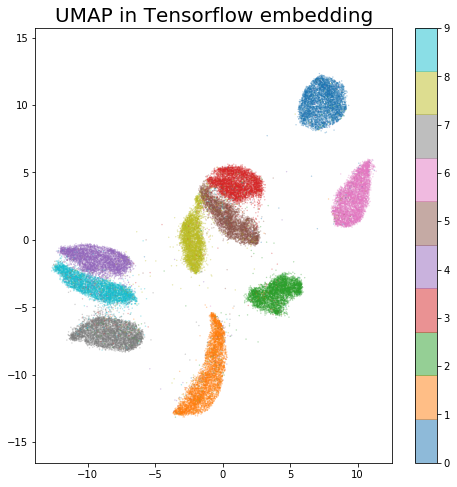

In [28]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=Y_train.astype(int),
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [29]:
model._history.keys()

dict_keys(['loss'])

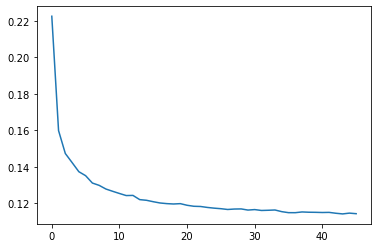

In [30]:
plt.plot(model._history['loss'])

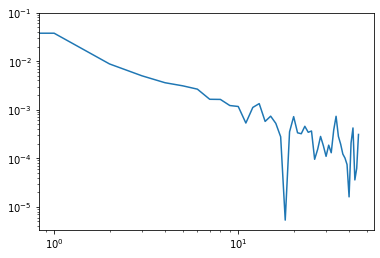

In [31]:
plt.loglog(np.abs(np.gradient(model._history['loss'])))

In [32]:
import matplotlib.pyplot as plt

In [33]:
nex = 10
x = X_train[:nex]
x_recon = model.decoder.predict(model.encoder.predict(x))
fig, axs = plt.subplots(ncols=10, nrows = 2, figsize=(nex, 2))
for i in range(nex):
    axs[0, i].matshow(np.squeeze(x[i]))
    axs[1, i].matshow(tf.nn.sigmoid(np.squeeze(x_recon[i].reshape(dims))))
for ax in axs.flatten():
    ax.axis('off')

AttributeError: 'NoneType' object has no attribute 'predict'

In [ ]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

In [ ]:
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=7 * 7 * 256, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    tf.keras.layers.Conv2DTranspose(
        filters=128, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    )
])
decoder.summary()